# Neural Graphics Ex1: Training Your Own Diffusion Model!

## Setup environment

In [ ]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [ ]:
# Import essential modules. Feel free to add whatever you need.
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Seed your work
To be able to reproduce your code, please use a random seed from this point onward.

In [ ]:
def seed_everything(seed):
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

YOUR_SEED = 180 # modify if you want
seed_everything(YOUR_SEED)

## 1. Basic Ops and UNet blocks
**Notations:**  
 * `Conv2D(kernel_size, stride, padding)` is `nn.Conv2d()`  
 * `BN` is `nn.BatchNorm2d()`  
 * `GELU` is `nn.GELU()`  
 * `ConvTranspose2D(kernel_size, stride, padding)` is `nn.ConvTranspose2d()`  
 * `AvgPool(kernel_size)` is `nn.AvgPool2d()`  
 * `Linear` is `nn.Linear()`  
 * `N`, `C`, `W` and `H` are batch size, channels num, weight and height respectively


### Basic Ops

In [ ]:
class Conv(nn.Module):
    """
    A convolutional layer that doesn’t change the image
    resolution, only the channel dimension
    Applies nn.Conv2d(3, 1, 1) followed by BN and GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the Conv layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.conv =nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(num_features=out_channels),
                                nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H, W) output tensor.
        """
        return self.conv(x)

class DownConv(nn.Module):
    """
        A convolutional layer downsamples the tensor by 2.
        The layer consists of Conv2D(3, 2, 1) followed by BN and GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the DownConv layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.downconv =nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=3, stride=2, padding=1),
                                nn.BatchNorm2d(num_features=out_channels),
                                nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H/2, W/2) output tensor.
        """
        return self.downconv(x)


class UpConv(nn.Module):
    """
    A convolutional layer that upsamples the tensor by 2.
    The layer consists of ConvTranspose2d(4, 2, 1) followed by
    BN and GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the UpConv layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.upconv =nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=4, stride=2, padding=1),
                                nn.BatchNorm2d(num_features=out_channels),
                                nn.GELU())


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H*2, W*2) output tensor.
        """
        return self.upconv(x)


class Flatten(nn.Module):
    """
    Average pooling layer that flattens a 7x7 tensor into a 1x1 tensor.
    The layer consists of AvgPool followed by GELU.
    """
    def __init__(self):
        super().__init__()
        self.flatten = nn.Sequential(nn.AvgPool2d(kernel_size=7),
                                     nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, 7, 7) input tensor.

        Returns:
            (N, C, 1, 1) output tensor.
        """
        return self.flatten(x)


class Unflatten(nn.Module):
    """
      Convolutional layer that unflattens/upsamples a 1x1 tensor into a
      7x7 tensor. The layer consists of ConvTranspose2D(7, 7, 0)
      followed by BN and GELU.
    """
    def __init__(self, in_channels: int):
        """
        Initializes Unflatten layer
        Args:
            in_channels (int): The number of input channels
        """
        super().__init__()
        self.unflatten = nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels,out_channels=in_channels,
                                                          kernel_size=7, stride=7,padding=0),
                                       nn.BatchNorm2d(num_features=in_channels),
                                       nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, 1, 1) input tensor.

        Returns:
            (N, in_channels, 7, 7) output tensor.
        """
        return self.unflatten(x)

class FC(nn.Module):
    """
    Fully connected layer, consisting of nn.linear followed by GELU.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the FC layer
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.fc =nn.Sequential(nn.Linear(in_features=in_channels, out_features=out_channels),
                               nn.GELU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels) input tensor.

        Returns:
            (N, out_channels) output tensor.
        """
        return self.fc(x)



### UNet Blocks

In [ ]:
class ConvBlock(nn.Module):
    """
    Two consecutive Conv operations.
    Note that it has the same input and output shape as Conv.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes ConvBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.convblock = nn.Sequential(Conv(in_channels, in_channels),
                                       Conv(in_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H, W) output tensor.
        """
        return self.convblock(x)


class DownBlock(nn.Module):
    """
    DownConv followed by ConvBlock. Note that it has the same input and output
    shape as DownConv.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes DownBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.downconv = nn.Sequential(DownConv(in_channels, out_channels),
                                      ConvBlock(out_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H/2, W/2) output tensor.
        """
        return self.downconv(x)


class UpBlock(nn.Module):
    """
    UpConv followed by ConvBlock.
    Note that it has the same input and output shape as UpConv
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes UpBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.upconv = nn.Sequential(UpConv(in_channels, out_channels),
                                    ConvBlock(out_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels, H, W) input tensor.

        Returns:
            (N, out_channels, H*2, W*2) output tensor.
        """
        return self.upconv(x)

class FCBlock(nn.Module):
    """
    Fully-connected Block, consisting of FC layer followed by Linear layer. Note
    that it has the same input and output shape as FC.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes FCBlock
        Args:
            in_channels (int): The number of input channels
            out_channels (int): The number of output channels
        """
        super().__init__()
        self.fcblock = nn.Sequential(FC(in_channels,out_channels),
                                     nn.Linear(out_channels,out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_channels) input tensor.

        Returns:
            (N, out_channels) output tensor.
        """
        return self.fcblock(x)

## 2. Unconditional Diffusion Framework


### 2.1 UNet architecture

In [ ]:
class DenoisingUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.ConvIn = ConvBlock(in_channels, num_hiddens)
        self.DownBlock1 = DownBlock(num_hiddens, num_hiddens)
        self.DownBlock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.Flatten = Flatten()
        self.Unflatten = Unflatten(2*num_hiddens)
        self.UpBlock1 = UpBlock(4*num_hiddens, num_hiddens)
        self.UpBlock2 = UpBlock(2*num_hiddens, num_hiddens)
        self.ConvOut = ConvBlock(2*num_hiddens, num_hiddens)
        self.Conv2D = nn.Conv2d(num_hiddens, in_channels, kernel_size=(3,3), padding=(1,1))

        # time
        self.FcBlock1 = FCBlock(1, 2*num_hiddens)
        self.FcBlock2 = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N, 1) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Down

        res_high = self.ConvIn(x)
        res_mid = self.DownBlock1(res_high)
        res_low = self.DownBlock2(res_mid)
        flattened = self.Flatten(res_low)

        # time in

        t_low = self.FcBlock1(t).unsqueeze(-1).unsqueeze(-1)
        t_mid = self.FcBlock2(t).unsqueeze(-1).unsqueeze(-1)

        # Up

        out = self.Unflatten(flattened) + t_low
        out = self.UpBlock1(torch.cat((res_low, out), dim=1)) + t_mid
        out = self.UpBlock2(torch.cat((res_mid, out), dim=1))
        out = self.Conv2D(self.ConvOut(torch.cat((res_high, out), dim=1)))

        return out

### 2.1 DDPM Forward and Inverse Process


In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int, device: str = 'cuda') -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    out_dict = {
        'betas': betas,
        'alphas': alphas,
        'alpha_bars': alpha_bars,
    }
    return out_dict


In [ ]:

def ddpm_forward(
    unet: DenoisingUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper (not including gradient step).

    Args:
        unet: DenoisingUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    device = x_0.device
    N = x_0.shape[0]
    ts = torch.randint(1, num_ts+1, (N,)).to(device)
    epsilons = torch.randn(x_0.shape).to(device)
    alpha_bars = ddpm_schedule['alpha_bars'][ts-1].to(device)
    alpha_bars = alpha_bars.view(-1, 1, 1, 1)
    xt_vec = torch.sqrt(alpha_bars)*x_0 + torch.sqrt(1-alpha_bars)*epsilons
    ts_normalized = (ts/num_ts).view(-1,1)
    epsilons_est = unet(xt_vec,ts_normalized)
    loss = nn.functional.mse_loss(epsilons, epsilons_est)

    return loss

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: DenoisingUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    batch_size: int,
    num_ts: int
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper.

    Args:
        unet: DenoisingUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    device = next(unet.parameters()).device
    H, W = img_wh
    C = unet.in_channels
    xt = torch.randn(batch_size, C, H, W, device=device)

    alpha_bars = ddpm_schedule['alpha_bars']
    alphas = ddpm_schedule['alphas']
    beta = ddpm_schedule['betas']

    for t in range(num_ts,0,-1):
        z = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)
        ath = alpha_bars[t-1].view(-1, 1, 1, 1)
        at = alphas[t-1].view(-1, 1, 1, 1)

        t_norm = torch.full((batch_size, 1), t / num_ts, device=device)
        epsilons_est = unet(xt,t_norm)

        x0_est = (1/torch.sqrt(ath))*(xt-torch.sqrt(1-ath)*epsilons_est)

        ath_next = alpha_bars[t-2].view(-1, 1, 1, 1) if t > 1 else torch.ones_like(ath)
        bt = beta[t-1].view(-1, 1, 1, 1)

        xt = (torch.sqrt(ath_next)*bt/(1-ath))*x0_est + (torch.sqrt(at)*(1-ath_next)/(1-ath))*xt + torch.sqrt(bt)*z

    return xt

In [ ]:
# Do Not Modify
class DDPM(nn.Module):
    def __init__(
        self,
        unet: DenoisingUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.beta_boundries = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        batch_size: int
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, batch_size, self.num_ts
        )

### 2.3 Train your denoiser

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

def load_MNIST(with_transform):
    # Init MNIST data loaders
    if not with_transform:
      preprocess = ToTensor()
    else:
      preprocess = transforms.Compose(
          [
              transforms.ToTensor(),
              transforms.Normalize([0.5], [0.5]),
          ]
    )

    train_data = MNIST(root='./data', train=True, download=True, transform=preprocess)
    test_data = MNIST(root='./data', train=False, download=True, transform=preprocess)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(test_data, batch_size=eval_batch_size, shuffle=True) #Not usefull now, but will be for evaluating class-conditioned denoiser (3.3)

    return train_data, test_data, train_loader, eval_loader


def postprocess(images):
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).round().astype("uint8")
    return images

In [ ]:
import os
import shutil

def save_checkpoint(epoch, model, optimizer, scheduler, batch_losses, epoch_losses, CHECKPOINT_DIR):

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'batch_losses': batch_losses,
        'epoch_losses': epoch_losses,
    },  os.path.join(CHECKPOINT_DIR, f'ddpm_epoch_{epoch}.pth'))
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(CHECKPOINT_DIR, train_from_scratch, num_hidden, lr, num_epochs, clear_folder):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Init denoiser and DDPM wrapper
    denosier_unet = DenoisingUNet(in_channels=1 , num_hiddens=num_hidden)
    ddpm = DDPM(denosier_unet, num_ts=T)

    # Optimizer and device setup - Adam optimizer with exponential learning rate decay
    optimizer = torch.optim.Adam(ddpm.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma = 0.1**(1.0/num_epochs))
    ddpm.to(device)

    # Create/Clear folder if necessary
    if clear_folder and os.path.exists(CHECKPOINT_DIR):
        print(f"Clearing all checkpoints in: {CHECKPOINT_DIR}")
        # Delete the whole directory and recreate it
        shutil.rmtree(CHECKPOINT_DIR)
    if not os.path.exists(CHECKPOINT_DIR):
        os.makedirs(CHECKPOINT_DIR)
        print(f"Created directory: {CHECKPOINT_DIR}")

    # Logic to find the latest checkpoint and load it
    latest_checkpoint = None

    # Check for existing files in the directory
    if os.path.exists(CHECKPOINT_DIR):
        files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
        if files:
            # Sort by epoch number (assumes name format 'ddpm_epoch_X.pth')
            files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            latest_checkpoint = os.path.join(CHECKPOINT_DIR, files[-1])

    if (not latest_checkpoint is None) and (not train_from_scratch):
        print(f"Loading checkpoint: {latest_checkpoint}")
        checkpoint = torch.load(latest_checkpoint)

        ddpm.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch']
        batch_losses = checkpoint.get('batch_losses', [])
        epoch_losses = checkpoint.get('epoch_losses', [])
        print(f"Resuming from epoch {start_epoch}")

    else:
        start_epoch = 0
        batch_losses = []
        epoch_losses = []
        print(f"training from scratch")

    if start_epoch > num_epochs:
      raise IOError(f'The loaded model epoch was {start_epoch}, while the request number of epochs is {num_epochs}.')

    return start_epoch, ddpm, optimizer, scheduler, batch_losses, epoch_losses

Clearing all checkpoints in: /content/drive/MyDrive/NeuralGraphicsEX1/ddpm_checkpoints
Created directory: /content/drive/MyDrive/NeuralGraphicsEX1/ddpm_checkpoints
training from scratch


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [0/938], Loss: 1.0885
Epoch [1/20], Step [100/938], Loss: 0.2974
Epoch [1/20], Step [200/938], Loss: 0.2701
Epoch [1/20], Step [300/938], Loss: 0.1818
Epoch [1/20], Step [400/938], Loss: 0.1546
Epoch [1/20], Step [500/938], Loss: 0.1489
Epoch [1/20], Step [600/938], Loss: 0.0911
Epoch [1/20], Step [700/938], Loss: 0.0855
Epoch [1/20], Step [800/938], Loss: 0.0675
Epoch [1/20], Step [900/938], Loss: 0.0580
Epoch [1/20] - Average Loss: 0.1729
Generating samples for epoch 1...


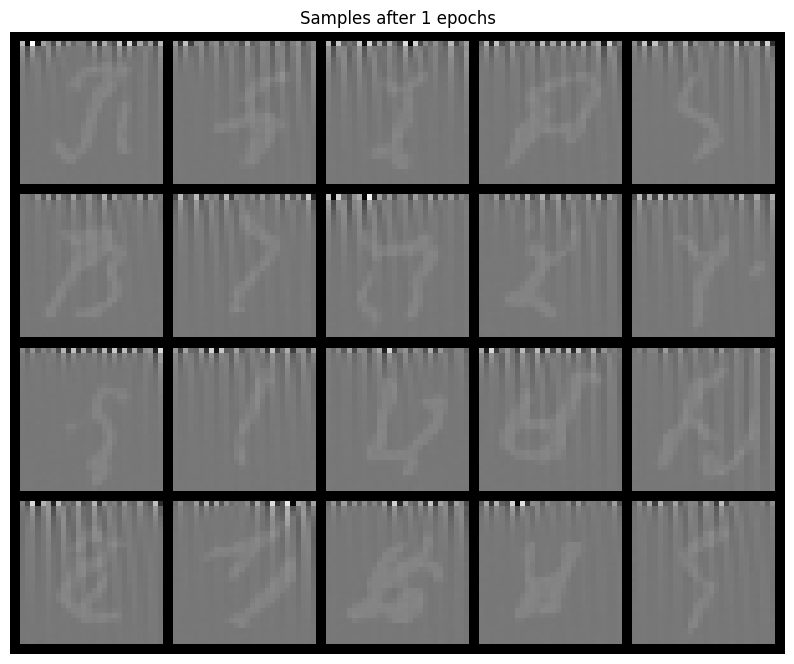

  5%|▌         | 1/20 [02:02<38:52, 122.74s/it]

Checkpoint saved at epoch 1
Epoch [2/20], Step [0/938], Loss: 0.0734
Epoch [2/20], Step [100/938], Loss: 0.0646
Epoch [2/20], Step [200/938], Loss: 0.0749
Epoch [2/20], Step [300/938], Loss: 0.0615
Epoch [2/20], Step [400/938], Loss: 0.0636
Epoch [2/20], Step [500/938], Loss: 0.0488
Epoch [2/20], Step [600/938], Loss: 0.0560
Epoch [2/20], Step [700/938], Loss: 0.0402
Epoch [2/20], Step [800/938], Loss: 0.0566
Epoch [2/20], Step [900/938], Loss: 0.0321
Epoch [2/20] - Average Loss: 0.0548
Generating samples for epoch 2...


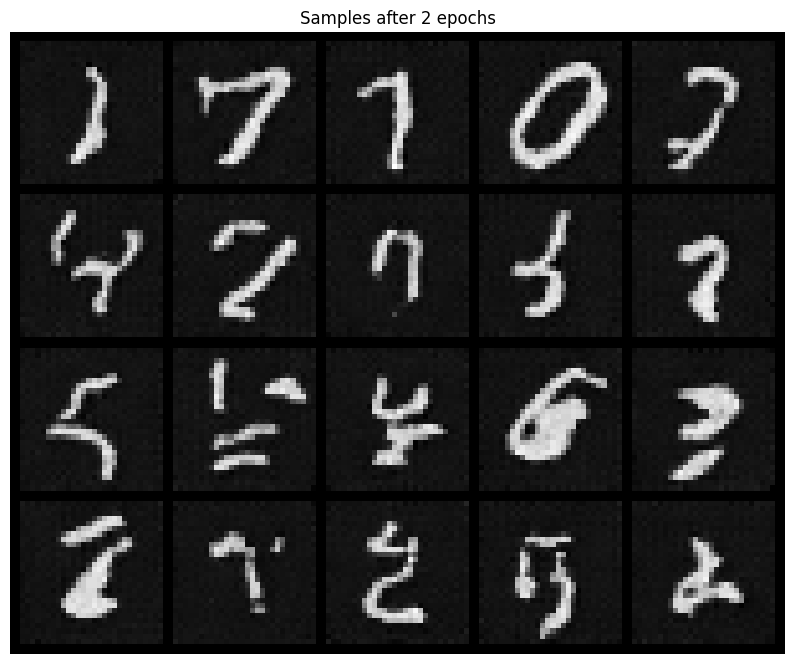

 10%|█         | 2/20 [04:02<36:22, 121.24s/it]

Checkpoint saved at epoch 2
Epoch [3/20], Step [0/938], Loss: 0.0311
Epoch [3/20], Step [100/938], Loss: 0.0345
Epoch [3/20], Step [200/938], Loss: 0.0525
Epoch [3/20], Step [300/938], Loss: 0.0327
Epoch [3/20], Step [400/938], Loss: 0.0346
Epoch [3/20], Step [500/938], Loss: 0.0444
Epoch [3/20], Step [600/938], Loss: 0.0372
Epoch [3/20], Step [700/938], Loss: 0.0355
Epoch [3/20], Step [800/938], Loss: 0.0372
Epoch [3/20], Step [900/938], Loss: 0.0370
Epoch [3/20] - Average Loss: 0.0368
Generating samples for epoch 3...


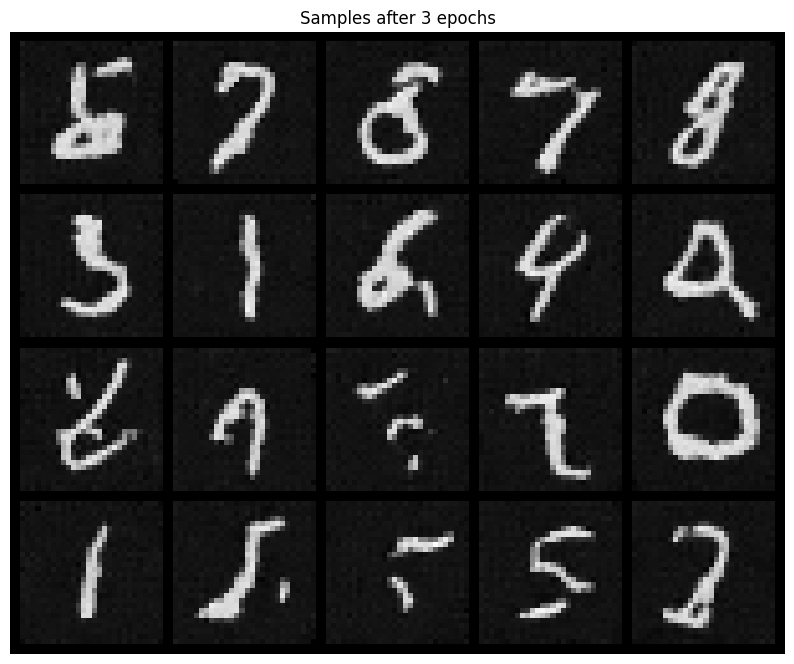

 15%|█▌        | 3/20 [06:02<34:08, 120.47s/it]

Checkpoint saved at epoch 3
Epoch [4/20], Step [0/938], Loss: 0.0380
Epoch [4/20], Step [100/938], Loss: 0.0298
Epoch [4/20], Step [200/938], Loss: 0.0361
Epoch [4/20], Step [300/938], Loss: 0.0339
Epoch [4/20], Step [400/938], Loss: 0.0348
Epoch [4/20], Step [500/938], Loss: 0.0350
Epoch [4/20], Step [600/938], Loss: 0.0378
Epoch [4/20], Step [700/938], Loss: 0.0346
Epoch [4/20], Step [800/938], Loss: 0.0299
Epoch [4/20], Step [900/938], Loss: 0.0251
Epoch [4/20] - Average Loss: 0.0340


 20%|██        | 4/20 [07:57<31:31, 118.24s/it]

Checkpoint saved at epoch 4
Epoch [5/20], Step [0/938], Loss: 0.0293
Epoch [5/20], Step [100/938], Loss: 0.0371
Epoch [5/20], Step [200/938], Loss: 0.0317
Epoch [5/20], Step [300/938], Loss: 0.0257
Epoch [5/20], Step [400/938], Loss: 0.0299
Epoch [5/20], Step [500/938], Loss: 0.0268
Epoch [5/20], Step [600/938], Loss: 0.0378
Epoch [5/20], Step [700/938], Loss: 0.0394
Epoch [5/20], Step [800/938], Loss: 0.0260
Epoch [5/20], Step [900/938], Loss: 0.0392
Epoch [5/20] - Average Loss: 0.0319
Generating samples for epoch 5...


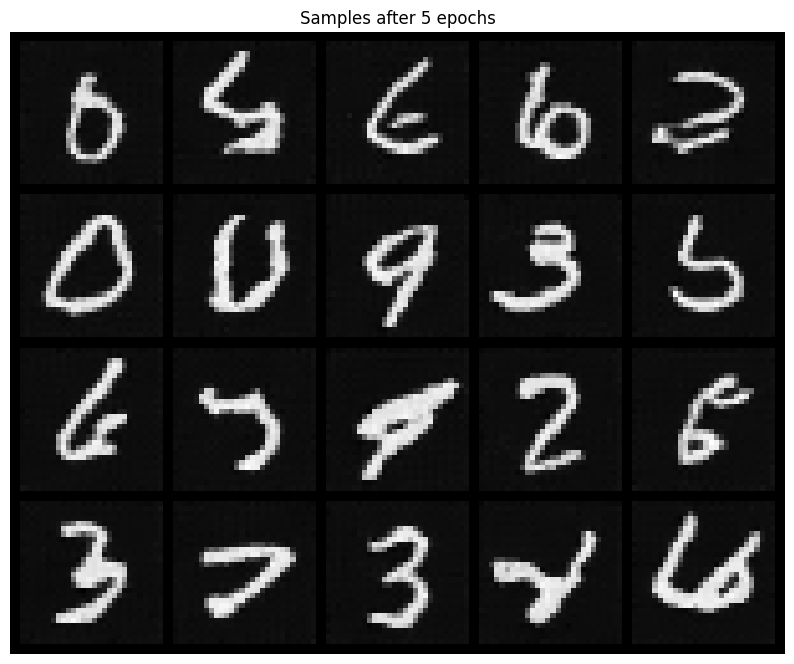

 25%|██▌       | 5/20 [09:56<29:39, 118.66s/it]

Checkpoint saved at epoch 5
Epoch [6/20], Step [0/938], Loss: 0.0303
Epoch [6/20], Step [100/938], Loss: 0.0363
Epoch [6/20], Step [200/938], Loss: 0.0249
Epoch [6/20], Step [300/938], Loss: 0.0344
Epoch [6/20], Step [400/938], Loss: 0.0361
Epoch [6/20], Step [500/938], Loss: 0.0256
Epoch [6/20], Step [600/938], Loss: 0.0285
Epoch [6/20], Step [700/938], Loss: 0.0405
Epoch [6/20], Step [800/938], Loss: 0.0300
Epoch [6/20], Step [900/938], Loss: 0.0285
Epoch [6/20] - Average Loss: 0.0312


 30%|███       | 6/20 [11:51<27:20, 117.21s/it]

Checkpoint saved at epoch 6
Epoch [7/20], Step [0/938], Loss: 0.0272
Epoch [7/20], Step [100/938], Loss: 0.0316
Epoch [7/20], Step [200/938], Loss: 0.0287
Epoch [7/20], Step [300/938], Loss: 0.0289
Epoch [7/20], Step [400/938], Loss: 0.0310
Epoch [7/20], Step [500/938], Loss: 0.0235
Epoch [7/20], Step [600/938], Loss: 0.0317
Epoch [7/20], Step [700/938], Loss: 0.0279
Epoch [7/20], Step [800/938], Loss: 0.0303
Epoch [7/20], Step [900/938], Loss: 0.0358
Epoch [7/20] - Average Loss: 0.0298


 35%|███▌      | 7/20 [13:45<25:12, 116.35s/it]

Checkpoint saved at epoch 7
Epoch [8/20], Step [0/938], Loss: 0.0260
Epoch [8/20], Step [100/938], Loss: 0.0274
Epoch [8/20], Step [200/938], Loss: 0.0313
Epoch [8/20], Step [300/938], Loss: 0.0265
Epoch [8/20], Step [400/938], Loss: 0.0209
Epoch [8/20], Step [500/938], Loss: 0.0410
Epoch [8/20], Step [600/938], Loss: 0.0435
Epoch [8/20], Step [700/938], Loss: 0.0252
Epoch [8/20], Step [800/938], Loss: 0.0270
Epoch [8/20], Step [900/938], Loss: 0.0309
Epoch [8/20] - Average Loss: 0.0296


 40%|████      | 8/20 [15:39<23:08, 115.69s/it]

Checkpoint saved at epoch 8
Epoch [9/20], Step [0/938], Loss: 0.0258
Epoch [9/20], Step [100/938], Loss: 0.0353
Epoch [9/20], Step [200/938], Loss: 0.0233
Epoch [9/20], Step [300/938], Loss: 0.0328
Epoch [9/20], Step [400/938], Loss: 0.0302
Epoch [9/20], Step [500/938], Loss: 0.0257
Epoch [9/20], Step [600/938], Loss: 0.0283
Epoch [9/20], Step [700/938], Loss: 0.0313
Epoch [9/20], Step [800/938], Loss: 0.0349
Epoch [9/20], Step [900/938], Loss: 0.0307
Epoch [9/20] - Average Loss: 0.0285


 45%|████▌     | 9/20 [17:33<21:06, 115.16s/it]

Checkpoint saved at epoch 9
Epoch [10/20], Step [0/938], Loss: 0.0255
Epoch [10/20], Step [100/938], Loss: 0.0340
Epoch [10/20], Step [200/938], Loss: 0.0307
Epoch [10/20], Step [300/938], Loss: 0.0228


In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# eval setup
CHECKPOINT_DIR = "/content/drive/MyDrive/NeuralGraphicsEX1/ddpm_checkpoints"
train_from_scratch = False
clear_folder = True
eval_epochs = [1, 2, 3, 5, 10, 15, 20]
with_transform = True

# Hyper parameters - Modify if you wish
num_hidden = 128
batch_size = 64
num_epochs = 20
lr = 1e-3
img_wh = (28, 28)
eval_batch_size=20
T=300

# initial\load checkpoint
start_epoch, ddpm, optimizer, scheduler, batch_losses, epoch_losses = load_checkpoint(CHECKPOINT_DIR, train_from_scratch, num_hidden, lr, num_epochs, clear_folder)

# Init MNIST data loaders
train_data, test_data, train_loader, eval_loader = load_MNIST(with_transform)

for epoch in tqdm(range(start_epoch, num_epochs)):
  ddpm.train()  # Set the model to training mode
  epoch_loss = 0.0
  for batch, (data, label) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      loss = ddpm(data)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights
      batch_loss = loss.item()
      epoch_loss += batch_loss

      if batch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch}/{len(train_loader)}], Loss: {batch_loss:.4f}")
        batch_losses.append(batch_loss)

  avg_epoch_loss = epoch_loss / len(train_loader)
  epoch_losses.append(epoch_loss)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_epoch_loss:.4f}")
  scheduler.step()

  ddpm.eval() # changes the behaior of BN and Dropouts layers
  # YOUR EVAL CODE HERE.
  with torch.no_grad():

      if (epoch + 1) in eval_epochs:
          print(f"Generating samples for epoch {epoch + 1}...")

          samples = ddpm.sample(img_wh=img_wh, batch_size=eval_batch_size)
          if with_transform:
            samples = postprocess(samples)

          grid = vutils.make_grid(samples, nrow=int(eval_batch_size // 4), normalize=True)
          plt.figure(figsize=(10, 10))
          plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
          plt.title(f"Samples after {epoch + 1} epochs")
          plt.axis('off')
          plt.show()

          # Recommended: Checkpoint the model as suggested in the tips

  save_checkpoint(epoch+1, ddpm, optimizer, scheduler, batch_losses, epoch_losses, CHECKPOINT_DIR)

# Final Plotting Logic
plt.figure(figsize=(12, 5))

# Plot Batch Loss
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label='Batch Loss')
plt.title('Training Batch MSE Loss')
plt.xlabel('Iterations (every 100 steps)')
plt.ylabel('MSE Loss')
plt.legend()

# Plot Epoch Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Epoch Loss', color='orange')
plt.title('Training Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Total MSE Loss')
plt.legend()

plt.tight_layout()
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')

In [ ]:
# original training loop
import matplotlib.pyplot as plt
import torchvision.utils as vutils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters - Modify if you wish
num_hidden = 128
batch_size = 64
num_epochs = 20
lr = 1e-3
img_wh = (28, 28)
eval_batch_size=20
T=300
with_transform = True

# Init MNIST data loaders
train_data, test_data, train_loader, eval_loader = load_MNIST(with_transform)
# train_data = MNIST(root='./data', train=True, download=True, transform=ToTensor())
# test_data = MNIST(root='./data', train=False, download=True, transform=ToTensor())
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# eval_loader = DataLoader(test_data, batch_size=eval_batch_size, shuffle=True) #Not usefull now, but will be for evaluating class-conditioned denoiser (3.3)

# Init denoiser and DDPM wrapper
denosier_unet = DenoisingUNet(in_channels=1 , num_hiddens=num_hidden)
ddpm = DDPM(denosier_unet, num_ts=T)

# Optimizer and device setup - Adam optimizer with exponential learning rate decay
optimizer = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma = 0.1**(1.0/num_epochs))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ddpm.to(device)

for epoch in tqdm(range(num_epochs)):
  ddpm.train()  # Set the model to training mode
  epoch_loss = 0.0
  for batch, (data, label) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      loss = ddpm(data)
      torch.nn.utils.clip_grad_norm_(ddpm.parameters(), 1.0)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights
      batch_loss = loss.item()
      # YOUR CODE HERE.
      epoch_loss += batch_loss

      if batch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch}/{len(train_loader)}], Loss: {batch_loss:.4f}")

  avg_epoch_loss = epoch_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_epoch_loss:.4f}")
  scheduler.step()


  ddpm.eval() # changes the behaior of BN and Dropouts layers
  # YOUR EVAL CODE HERE.
  with torch.no_grad():

    if (epoch + 1) in [1, 2, 3, 4, 5, 10, 15, 20]:
        print(f"Generating samples for epoch {epoch + 1}...")

        samples = ddpm.sample(img_wh=img_wh, batch_size=eval_batch_size)

        grid = vutils.make_grid(samples, nrow=int(eval_batch_size // 4), normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Samples after {epoch + 1} epochs")
        plt.axis('off')
        plt.show()



## 3. Implementing class-conditioned diffusion framework with CFG


###3.1 Adding Class-Conditioning to UNet architecture

In [ ]:
class ConditionalDenoisingUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # YOUR CODE HERE.
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        self.ConvIn = ConvBlock(in_channels, num_hiddens)
        self.DownBlock1 = DownBlock(num_hiddens, num_hiddens)
        self.DownBlock2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.Flatten = Flatten()
        self.Unflatten = Unflatten(2*num_hiddens)
        self.UpBlock1 = UpBlock(4*num_hiddens, num_hiddens)
        self.UpBlock2 = UpBlock(2*num_hiddens, num_hiddens)
        self.ConvOut = ConvBlock(2*num_hiddens, num_hiddens)
        self.Conv2D = nn.Conv2d(num_hiddens, in_channels, kernel_size=(3,3), padding=(1,1))

        # time
        self.fc1_t = FCBlock(1, 2*num_hiddens)
        self.fc2_t = FCBlock(1, num_hiddens)

        # condition
        self.fc1_c = FCBlock(num_classes, 2*num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N, num_classes) float condition tensor.
            t: (N, 1) normalized time tensor.
            mask: (N, 1) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # YOUR CODE HERE.

        # Down

        res_high = self.ConvIn(x)
        res_mid = self.DownBlock1(res_high)
        res_low = self.DownBlock2(res_mid)
        flattened = self.Flatten(res_low)

        # time & condition in

        if not mask is None:
          c = c * mask

        t_low = self.fc1_t(t).unsqueeze(-1).unsqueeze(-1)
        t_mid = self.fc2_t(t).unsqueeze(-1).unsqueeze(-1)
        c_low = self.fc1_c(c).unsqueeze(-1).unsqueeze(-1)
        c_high = self.fc2_c(c).unsqueeze(-1).unsqueeze(-1)

        # Up

        out = c_low*self.Unflatten(flattened) + t_low
        out = c_high*self.UpBlock1(torch.cat((res_low, out), dim=1)) + t_mid
        out = self.UpBlock2(torch.cat((res_mid, out), dim=1))
        out = self.Conv2D(self.ConvOut(torch.cat((res_high, out), dim=1)))

        return out

###3.2 DDPM Forward and Inverse Process with CFG

In [ ]:
def ddpm_cfg_forward(
    unet: ConditionalDenoisingUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3 (not including gradient step).

    Args:
        unet: ConditionalDenoisingUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    device = x_0.device

    # initialize inputs
    N = x_0.shape[0]
    c = nn.functional.one_hot(c, num_classes=unet.num_classes).float()

    # get params
    alpha_bars = ddpm_schedule['alpha_bars'][ts-1].to(device)
    alpha_bars = alpha_bars.view(-1, 1, 1, 1)

    # randomize
    c = torch.zeros(N,1, device=device) if p_uncond > torch.rand(1) else c
    ts = torch.randint(1, num_ts+1, (N,), device=device)
    ts_normalized = (ts/num_ts).view(-1,1)
    epsilons = torch.randn(x_0.shape, device=device)

    # calculate loss
    xt_vec = torch.sqrt(alpha_bars)*x_0 + torch.sqrt(1-alpha_bars)*epsilons
    epsilons_est = unet(xt_vec, c, ts_normalized)
    loss = nn.functional.mse_loss(epsilons, epsilons_est)

    return loss


In [ ]:
@torch.inference_mode()
def ddpm_cfg_sample(
    unet: ConditionalDenoisingUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0
) -> torch.Tensor:
    """Algorithm 4.

    Args:
        unet: ConditionalDenoisingUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    device = next(unet.parameters()).device

    # initialize inputs
    c = nn.functional.one_hot(c, num_classes=unet.num_classes, device=device).float()
    c_0 = torch.zeros_like(c, device=device).float()
    H, W = img_wh
    C = unet.in_channels
    alpha_bars = ddpm_schedule['alpha_bars']
    alphas = ddpm_schedule['alphas']
    beta = ddpm_schedule['betas']

    # randomize input
    xt = torch.randn(batch_size, C, H, W, device=device)


    for t in range(num_ts,0,-1):

        # randomize
        z = torch.randn_like(xt) if t > 1 else torch.zeros_like(xt)

        # get params
        ath = alpha_bars[t-1].view(-1, 1, 1, 1)
        at = alphas[t-1].view(-1, 1, 1, 1)
        bt = beta[t-1].view(-1, 1, 1, 1)
        ath_next = alpha_bars[t-2].view(-1, 1, 1, 1) if t > 1 else torch.ones_like(ath)
        t_norm = torch.full((batch_size, 1), t / num_ts, device=device)

        # noise estimation
        epsilons_uncond = unet(xt,c_0,t_norm)
        epsilons_cond = unet(xt,c,t_norm)
        epsilon_est = epsilons_uncond + guidance_scale * (epsilons_cond-epsilons_uncond)

        # image generation step
        x0_est = (1/torch.sqrt(ath))*(xt-torch.sqrt(1-ath)*epsilons_est)
        xt = (torch.sqrt(ath_next)*bt/(1-ath))*x0_est + (torch.sqrt(at)*(1-ath_next)/(1-ath))*xt + torch.sqrt(bt)*z

    return xt

In [ ]:
# Do Not Modify
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ConditionalDenoisingUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_cfg_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0
    ):
        return ddpm_cfg_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale
        )

###3.3 Train your class-conditioned denoiser

In [ ]:
# YOUR CODE HERE.

###3.4 Experiment with different guidance sacles

In [ ]:
# YOUR CODE HERE.
